In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Thu Jun 18 15:55:04 PDT 2020


In [3]:
output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/00_bugfix/v7.0_prelim_nigeria/count_data/']

locations = ['Nigeria']

In [4]:
# available data frames

# births
# births_with_ntd
# birth_weight
# deaths
# gestational_age
# person_time
# population
# state_person_time
# transition_count
# ylds
# ylls

In [5]:
# NOTE: Measles does not appear to be an SIR cause model here.

In [6]:
# note: exclude iron deficiency for now

causes = ['diarrheal_diseases', 
       'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       'vitamin_a_deficiency']

causes_with_transitions = ['diarrheal_diseases', 'lower_respiratory_infections', 
                           'measles', 'vitamin_a_deficiency']

causes_with_birth_prevalence = ['neural_tube_defects','lower_respiratory_infections']

causes_with_ylls = ['diarrheal_diseases', 
       'lower_respiratory_infections', 'measles', 'neural_tube_defects']

causes_with_ylds = ['diarrheal_diseases', 
       'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       'vitamin_a_deficiency']

sir_causes = [] # this is empty for this model run, although measles should be here

In [7]:
pt = pd.read_hdf(output_dirs[0] + 'person_time.hdf')
pt = pt.loc[pt.scenario == 'baseline']
pt = pt.groupby(['input_draw','age_group','sex']).sum()

state_pt = pd.read_hdf(output_dirs[0] + 'state_person_time.hdf')
state_pt = state_pt.loc[state_pt.scenario == 'baseline']
state_pt = state_pt.loc[state_pt.cause == 'neural_tube_defects']
state_pt = state_pt.groupby(['input_draw','age_group','sex']).sum()

sus_pt = pd.read_hdf(output_dirs[0] + 'state_person_time.hdf')
sus_pt = sus_pt.loc[sus_pt.scenario == 'baseline']
sus_pt = sus_pt.loc[sus_pt.cause == 'susceptible_to_neural_tube_defects']
sus_pt = sus_pt.groupby(['input_draw','age_group','sex']).sum()

sus_pt.head()

value
input_draw age_group      sex                 
357        1_to_4         female  40482.318960
                          male    41155.348392
           early_neonatal female    209.765914
                          male      217.618070
           late_neonatal  female    621.133470

In [8]:
prev1 = state_pt / pt
prev1 = prev1.reset_index().groupby(['age_group','sex']).mean()
prev1

input_draw     value
age_group      sex                         
1_to_4         female       479.5  0.001502
               male         479.5  0.001197
early_neonatal female       479.5  0.001760
               male         479.5  0.001532
late_neonatal  female       479.5  0.001663
               male         479.5  0.001391
post_neonatal  female       479.5  0.001579
               male         479.5  0.001463

In [9]:
prev2 = state_pt / (state_pt + sus_pt)
prev2 = prev2.reset_index().groupby(['age_group','sex']).mean()
prev2

input_draw     value
age_group      sex                         
1_to_4         female       479.5  0.001502
               male         479.5  0.001198
early_neonatal female       479.5  0.001758
               male         479.5  0.001530
late_neonatal  female       479.5  0.001664
               male         479.5  0.001392
post_neonatal  female       479.5  0.001580
               male         479.5  0.001463

In [10]:
# get model results from fixed_scenarios folder

def get_cause_specific_model_results(cause):
    master_data = pd.DataFrame()
    for i in list(range(len(output_dirs))):
        pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
        pt = (pt.where(pt['scenario'] == 'baseline').dropna()
              .groupby(['input_draw','age_group'], as_index=False).sum()
              .rename(columns={'value':'person_time'}))
        state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        state_pt = (state_pt.where(state_pt['cause'].str.contains(cause))
                   .where(state_pt['scenario'] == 'baseline').dropna()
                   .groupby(['age_group','cause','input_draw'], as_index=False).sum())
        state_pt = pd.pivot_table(state_pt, index=['input_draw','age_group'], columns='cause',
                              values='value').reset_index()
        state_pt = (state_pt.rename(columns={f'susceptible_to_{cause}':'susceptible_person_time',
                                           f'{cause}':'infected_person_time'}))
        if cause in sir_causes:
            state_pt = state_pt.drop(columns=f'recovered_from_{cause}_person_time')  
            
        data = pt.merge(state_pt, right_on=['input_draw','age_group'],
                     left_on=['input_draw','age_group'])
        data['prevalence'] = data['infected_person_time'] / data['person_time']
        
        if cause in causes_with_ylls:
            deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
            deaths = (deaths.where(deaths['scenario'] == 'baseline').dropna()
                      .where(deaths['cause'].str.contains(cause)).dropna()
                      .groupby(['input_draw','age_group'], as_index=False).sum()
                      .rename(columns={'value':'deaths'}))
            ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf')
            ylls = (ylls.where(ylls['scenario'] == 'baseline').dropna()
                   .where(ylls['cause'].str.contains(cause)).dropna()
                   .groupby(['input_draw','age_group'], as_index=False).sum()
                   .rename(columns={'value':'ylls'}))
            data = data.merge(deaths, right_on=['input_draw','age_group'],
                   left_on=['input_draw','age_group'])
            data = data.merge(ylls, right_on=['input_draw','age_group'],
                   left_on=['input_draw','age_group'])
            data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
            data['excess_mortality_rate'] = data['deaths'] / data['infected_person_time']
            data['yll_rate'] = data['ylls'] / data['person_time']
            
        if cause in causes_with_ylds:
            ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf')
            ylds = (ylds.where(ylds['scenario'] == 'baseline').dropna()
                   .where(ylds['cause'].str.contains(cause)).dropna()
                   .groupby(['input_draw','age_group'], as_index=False).sum()
                   .rename(columns={'value':'ylds'}))
            data = data.merge(ylds, right_on=['input_draw','age_group'],
                             left_on=['input_draw','age_group'])
            data['yld_rate'] = data['ylds'] / data['person_time']
        
        if cause in causes_with_transitions:
            transition = pd.read_hdf(output_dirs[i] + 'transition_count.hdf')
            transition = (transition.where(transition['measure'].str.contains(cause))
                          .where(transition['scenario'] == 'baseline').dropna())
            transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
            transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                                      values='value').reset_index()
                          .rename(columns={f'{cause}_to_susceptible_to_{cause}_event_count':'remission_count',
                                        f'{cause}_to_recovered_from_{cause}_event_count':'remission_count',
                                        f'susceptible_to_{cause}_to_{cause}_event_count':'incident_count'}))
            data = data.merge(transition, right_on=['age_group','input_draw'],
                             left_on=['age_group','input_draw'])
            data['incidence_rate'] = data['incident_count'] / data['susceptible_person_time']
            data['remission_rate'] = data['remission_count'] / data['infected_person_time']
            
        if cause in causes_with_birth_prevalence:
            births = pd.read_hdf(output_dirs[i] + 'births.hdf')
            births = (births.where(births['scenario'] == 'baseline').dropna()
                     .groupby(['input_draw']).sum())
            infected_births = pd.read_hdf(output_dirs[i] + 'births_with_ntd.hdf')
            infected_births = (infected_births.where(infected_births['scenario'] == 'baseline').dropna()
                              .groupby(['input_draw']).sum())
            birth_prevalence = infected_births / births
            birth_prevalence = birth_prevalence.reset_index().rename(columns={'value':'birth_prevalence'})
            data = data.merge(birth_prevalence, right_on=['input_draw'], 
                              left_on=['input_draw'])

        #data = data.groupby(['age_group'], as_index=False).mean()
        data['location'] = locations[i]
        master_data = master_data.append(data)
    master_data = (master_data.sort_values(by='location'))
                     #.drop(columns=['deaths','person_time',
                     #               'infected_person_time',
                     #              'susceptible_person_time','ylds','ylls']))#,'incident_count','remission_count']))
    return master_data

In [11]:
def get_model_results_for_all_causes(cause_list):
    data = pd.DataFrame()
    for i in cause_list:
        temp = get_cause_specific_model_results(i)
        temp['cause'] = i
        data = data.append(temp)
    data = data.fillna(0).drop(columns=['deaths','person_time',
                                'infected_person_time','susceptible_person_time',
                                'ylds','ylls','incident_count','remission_count'])
    data = data.sort_values(by='age_group')
    return data

In [12]:
# define function to load data from artifact for a specified cause and measure
# this function is called in the next function below

def load_artifact_data(cause, measure):
    master_art_data = pd.DataFrame()
    for i in ['nigeria']:
        art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/' + i + '.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
        if cause == 'vitamin_a_deficiency':
            data = art.load('risk_factor.' + cause + '.' + measure)
        else:
            data = art.load('cause.' + cause + '.' + measure)
        data_mean = pd.DataFrame(data.mean(axis=1)).rename(columns={0:'value'})
        data_limits = pd.DataFrame(data.quantile([0.025,0.975], axis=1)).transpose().rename(columns={0.025:'lower',
                                                                                                     0.975:'upper'})
        data = data_mean.merge(data_limits, right_index=True, left_index=True).reset_index()
        data['location'] = i.capitalize()
        data['measure'] = measure
        if measure == 'birth_prevalence':
            data['age_group'] = 'birth'
        else:
            data['age_group'] = 0
            data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                                   np.where(data['age_end'] == 1, 'post_neonatal',
                                            np.where(data['age_start'] == 1, '1_to_4', 
                                                    'late_neonatal')))
        master_art_data = master_art_data.append(data)
    return master_art_data

# define function to get artifact data for all locations, causes, measures

def get_cause_specific_artifact_data(cause_list):
    master_art = pd.DataFrame()
    for cause in cause_list:
        if cause == 'vitamin_a_deficiency':
            data = load_artifact_data(cause, 'exposure')
            data = data.loc[data.parameter == 'cat1']
            data['measure'] = 'prevalence'
        else:
            data = load_artifact_data(cause, 'prevalence')
            if cause in causes_with_ylls:
                for measure in ['cause_specific_mortality_rate','excess_mortality_rate']:
                    temp = load_artifact_data(cause, measure)
                    data = data.append(temp)
            if cause in causes_with_transitions:
                if cause == 'measles':
                    temp = load_artifact_data(cause, 'incidence_rate')
                    data = data.append(temp)
                else:
                    for measure in ['incidence_rate','remission_rate']:
                        temp = load_artifact_data(cause, measure)
                        data = data.append(temp)
            if cause in causes_with_birth_prevalence:
                temp = load_artifact_data(cause, 'birth_prevalence')
                data = data.append(temp)
        data['cause'] = cause
        master_art = master_art.append(data)
    master_art = master_art.drop(columns=['age_start','age_end','year_start','year_end'])
    master_art_avg = master_art.groupby(['location','cause','measure','age_group'], as_index=False).mean()
    #master_art_avg = pd.pivot_table(master_art_avg, index=['location','age_group'],
    #                 columns=['measure'], values='value').reset_index()
    #master_art_avg = master_art_avg.sort_values(by='location')
    return master_art_avg

In [13]:
model_results = get_model_results_for_all_causes(causes)
mean_model_results = model_results.groupby(['age_group','cause'], as_index=False).mean().sort_values(by='age_group')
artifact_data = get_cause_specific_artifact_data(causes)

for data_set in [model_results, mean_model_results, artifact_data]:
    data_set['age_group_order'] = np.where(data_set['age_group'] == 'early_neonatal', 1,
                                          np.where(data_set['age_group'] == 'late_neonatal', 2,
                                                  np.where(data_set['age_group'] == 'post_neonatal', 3,
                                                          np.where(data_set['age_group'] == '1_to_4', 4, 0))))
    
model_results = model_results.set_index(['cause','input_draw','age_group_order']).sort_index().reset_index()
mean_model_results = mean_model_results.set_index(['cause','age_group_order']).sort_index().reset_index()
artifact_data = artifact_data.set_index(['cause','age_group_order']).sort_index().reset_index()

mean_model_results.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To

,cause,age_group_order,age_group,birth_prevalence,cause_specific_mortality_rate,excess_mortality_rate,incidence_rate,input_draw,prevalence,remission_rate,yld_rate,yll_rate
0,diarrheal_diseases,1,early_neonatal,0.000000,0.017600,1.175157,2.192916,479.5,0.015286,53.074217,0.001896,1.546642
1,diarrheal_diseases,2,late_neonatal,0.000000,0.013497,0.398754,2.539226,479.5,0.033721,66.447844,0.004210,1.185756
2,diarrheal_diseases,3,post_neonatal,0.000000,0.009014,0.235967,2.666469,479.5,0.038677,66.088355,0.004916,0.787935
3,diarrheal_diseases,4,1_to_4,0.000000,0.002130,0.078332,1.831537,479.5,0.027232,65.461115,0.003427,0.181129
4,lower_respiratory_infections,1,early_neonatal,0.001712,0.122076,6.700316,0.044131,479.5,0.018246,38.411574,0.001210,10.728451


In [14]:
def make_multiple_plots(cause_list):
    for cause in cause_list:
        if cause == 'vitamin_a_deficiency':
            plot_measures = ['prevalence','incidence_rate','remission_rate']
        elif cause == 'lower_respiratory_infections':
            plot_measures = ['prevalence','incidence_rate','remission_rate',
                             'cause_specific_mortality_rate','excess_mortality_rate']
        elif cause == 'neural_tube_defects':
            plot_measures = ['prevalence','birth_prevalence',
                             'cause_specific_mortality_rate','excess_mortality_rate']
        else: #diarrheal diseases, measles
            plot_measures = ['prevalence','incidence_rate','remission_rate',
                             'cause_specific_mortality_rate','excess_mortality_rate']
        for measure in plot_measures:
            
            measure_s = model_results.loc[model_results.cause == cause]
            measure_mean = mean_model_results.loc[mean_model_results.cause == cause]
            measure_m = measure_mean.rename(columns={f'{measure}':'mean_model_value'})
            measure_gbd = artifact_data.loc[artifact_data.cause == cause]
            measure_g = measure_gbd.loc[measure_gbd.measure == measure]
            
            if measure == 'birth_prevalence':
                measure_s = measure_s.loc[measure_s.age_group == 'early_neonatal']
                    # note: for this dataset birth_prevalence is the same repeated for all age groups
                    # just selecting a single value for birth prevalence here
                measure_s['age_group'] = 'birth'
                measure_s_temp = pd.DataFrame.copy(measure_s)
                measure_s_temp['age_group'] = 'abirth'
                measure_s_temp['birth_prevalence'] = np.nan
                measure_s_temp2 = pd.DataFrame.copy(measure_s)
                measure_s_temp2['age_group'] = 'cbirth'
                measure_s_temp2['birth_prevalence'] = np.nan
                measure_s = measure_s.append([measure_s_temp,measure_s_temp2])
                measure_s = measure_s.sort_values(by=['age_group'])
                
                measure_m = measure_m.loc[measure_m.age_group == 'early_neonatal']
                measure_m = measure_m.append([measure_m,measure_m])
                measure_m['age_group'] = ['abirth','birth','cbirth']
                measure_m['mean_model_value'] = [np.nan, measure_m.mean_model_value.values[0],np.nan]
                
                measure_g = measure_g.append([measure_g,measure_g])
                measure_g['age_group'] = ['abirth','birth','cbirth']
                
            fig, ax = plt.subplots(figsize=(20, 10))
            clrs = sns.color_palette('husl', 1)

            g1 = sns.catplot(x='age_group', y=f'{measure}', ax=ax, data=measure_s, 
                             palette=clrs, label='Sim draws')
            
            sns.lineplot(x='age_group', y='value', palette=clrs, 
                         linewidth=2, ax=ax, data=measure_g, sort=False)
            
            ax.scatter(measure_m.age_group, measure_m.mean_model_value, s=250, marker='P', 
                       label='Sim mean', c=clrs)

            ax.fill_between(measure_g.age_group.values, measure_g.upper, 
                            measure_g.lower, alpha=0.3, label='GBD')

            ax.set_title(f'Nigeria, {measure.capitalize()} due to {cause.capitalize()}', fontsize=20)
            ax.set_xlabel('Age group', fontsize=18)
    
            l = ax.legend(loc=(1.02, 0.05), fontsize=12)
            labels = ['Sim draws']
            for text, label in zip(l.texts[1:5], labels):
                text.set_text(label)

            plt.close(g1.fig)

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


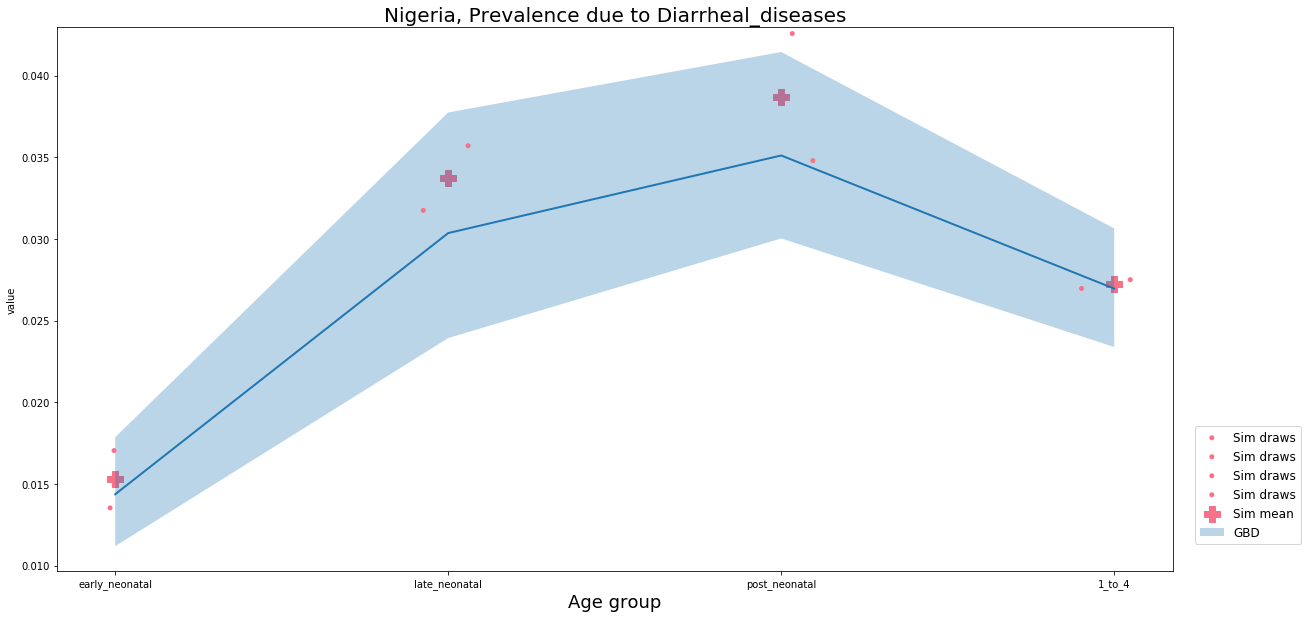

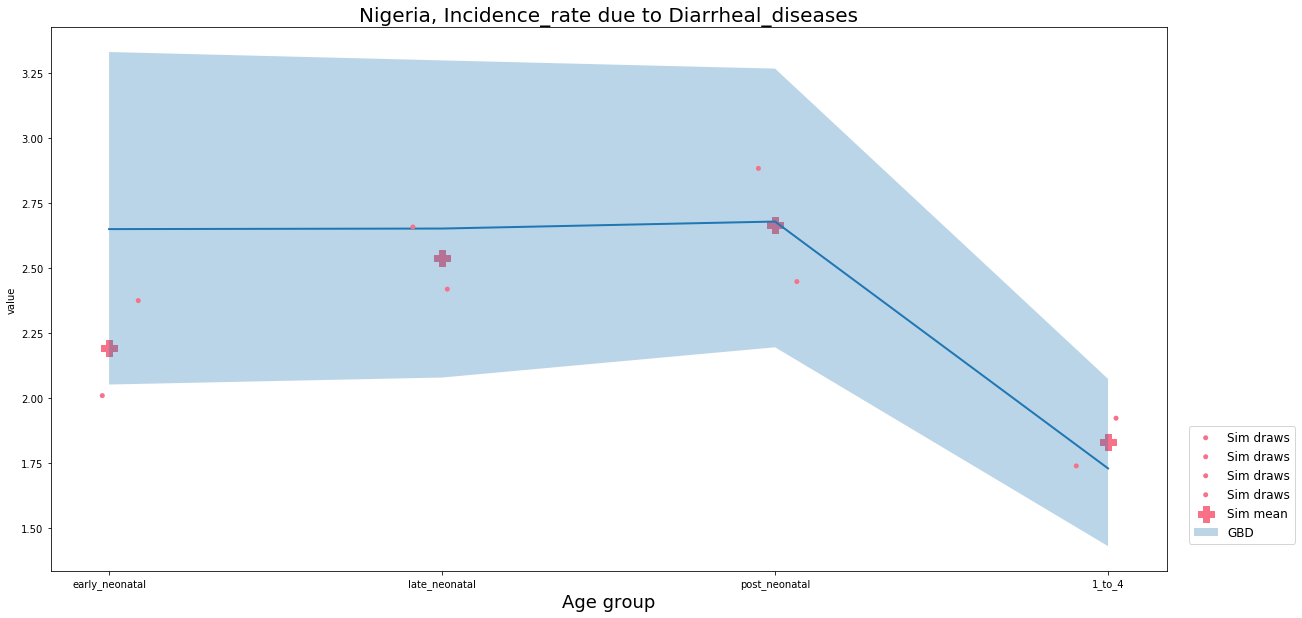

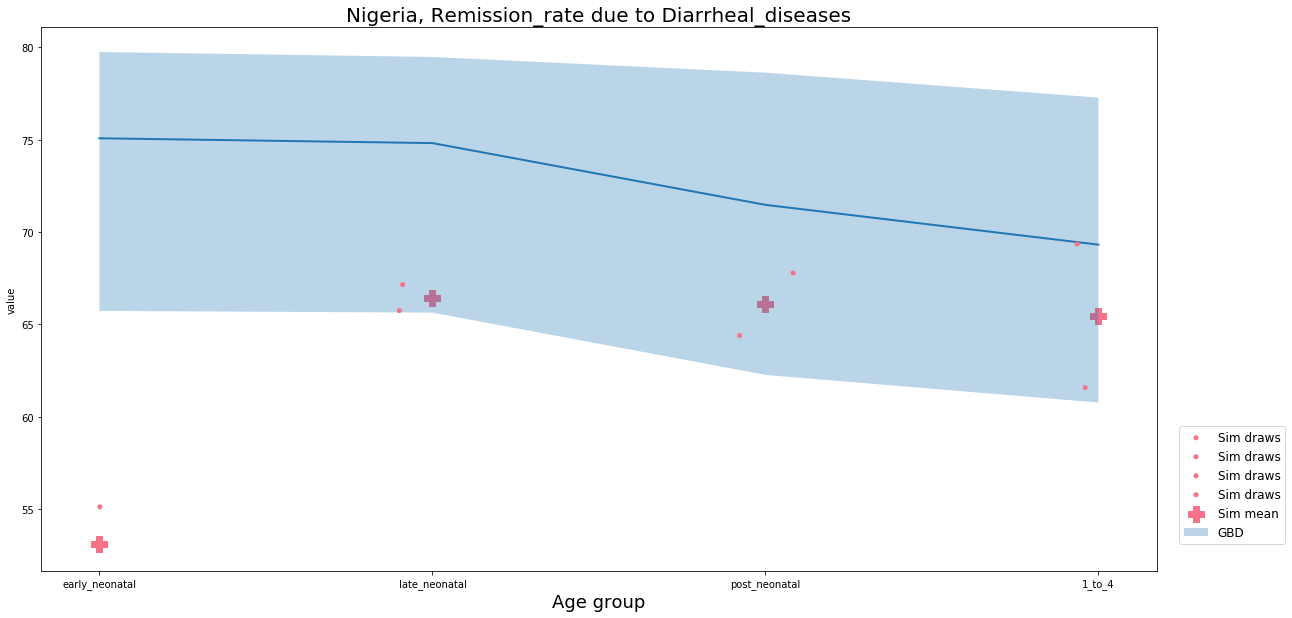

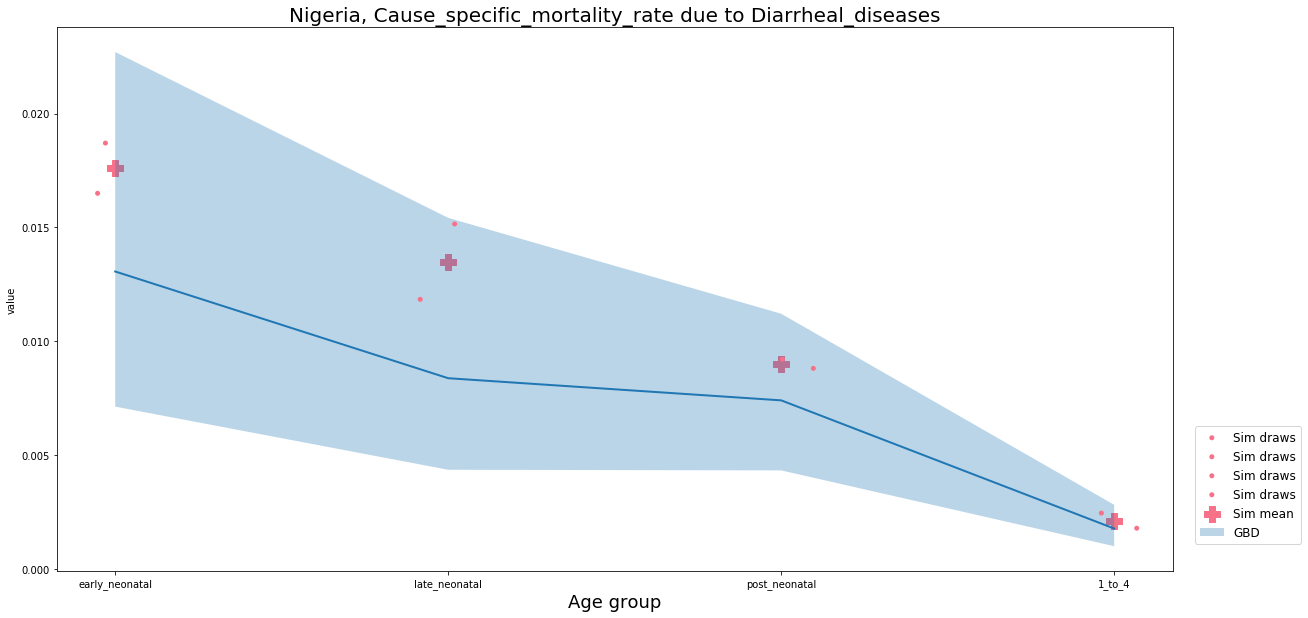

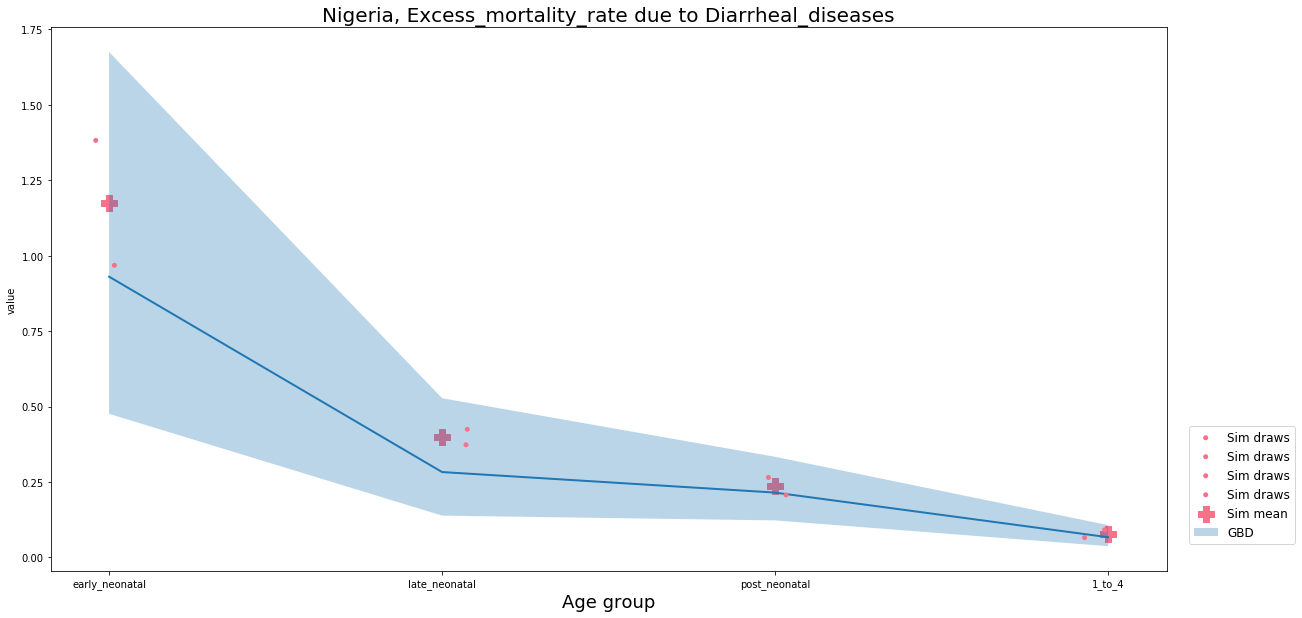

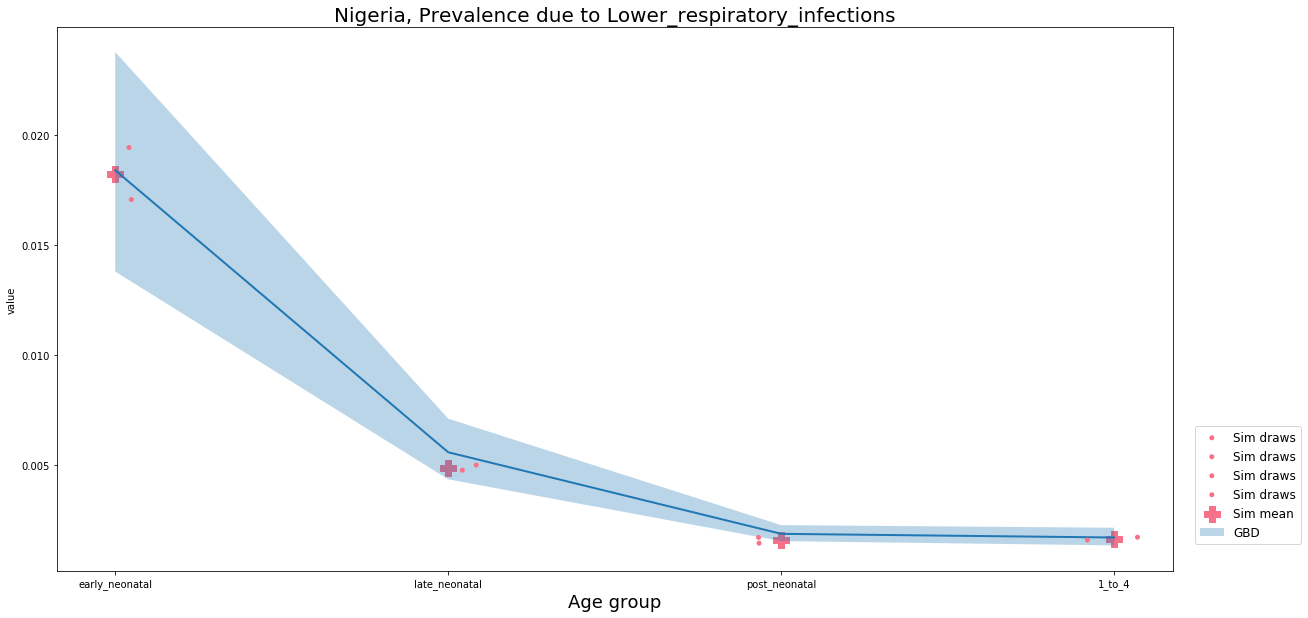

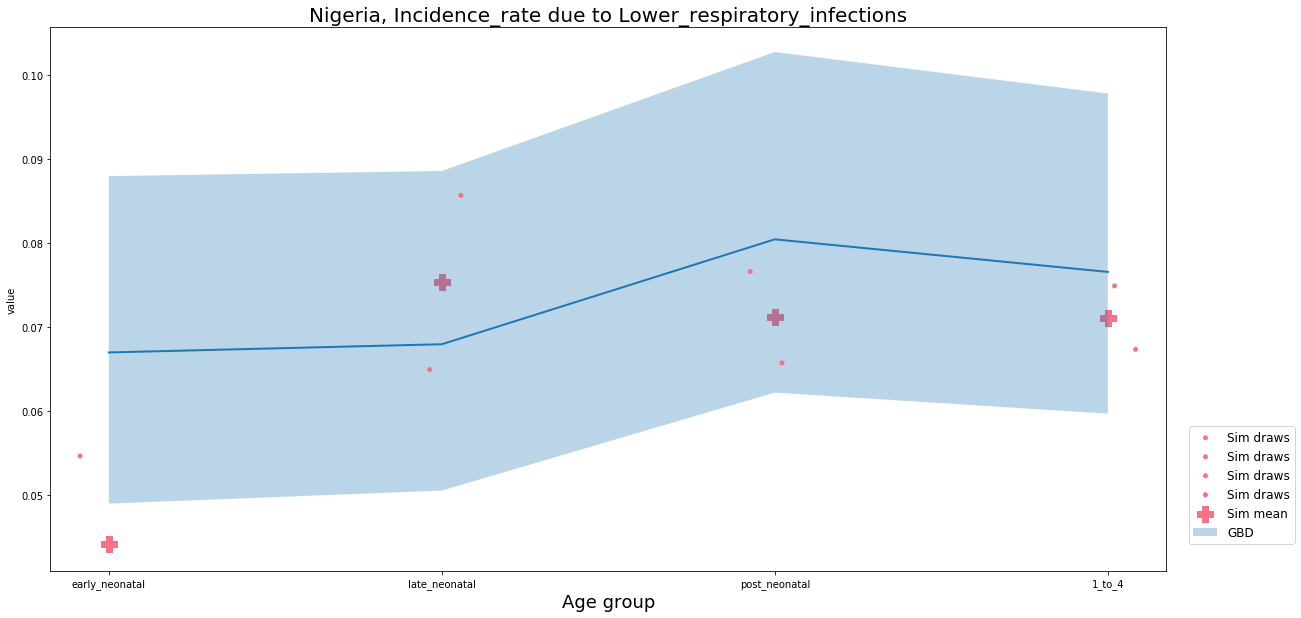

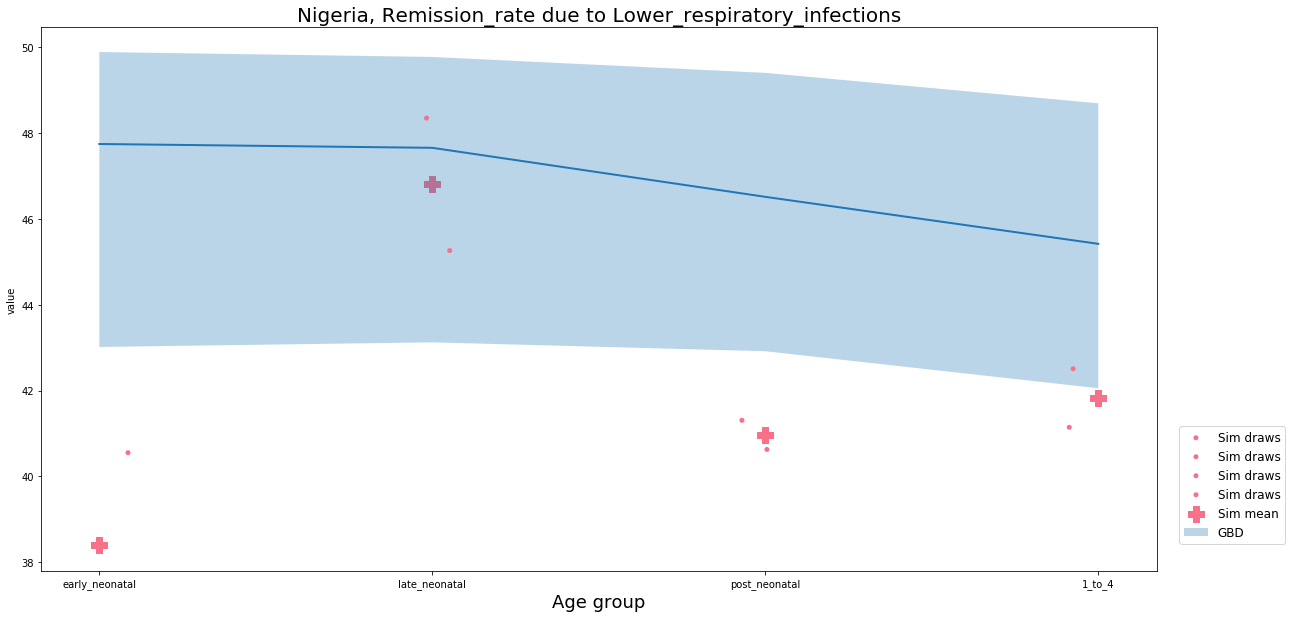

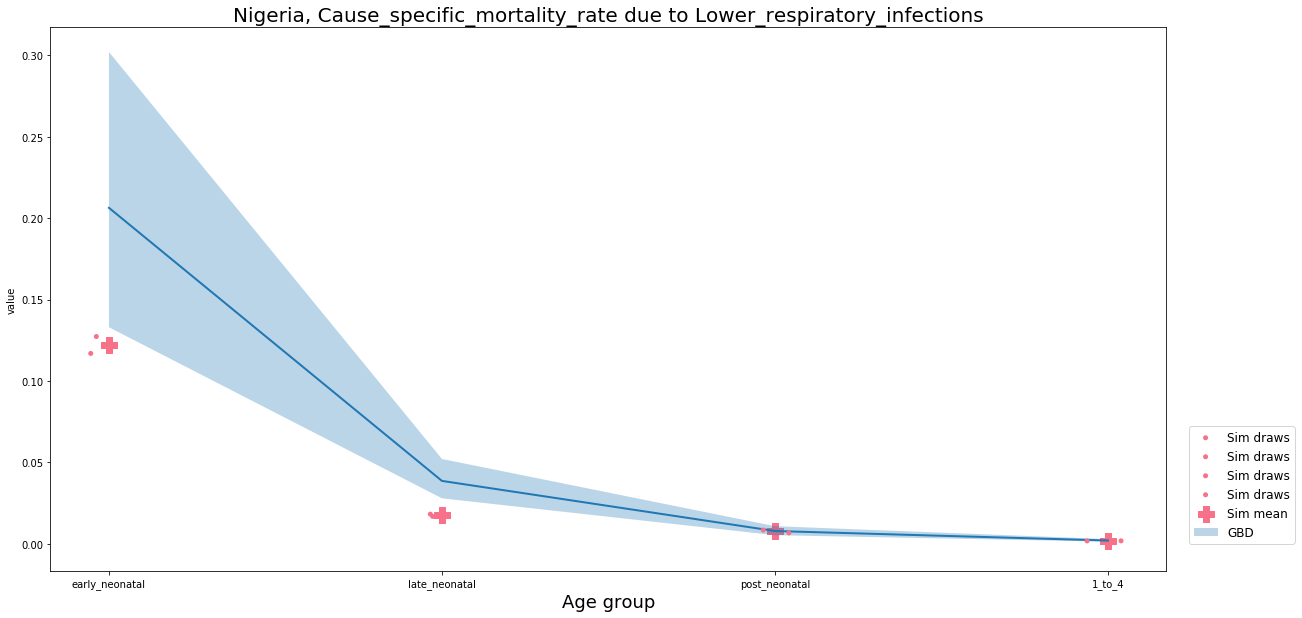

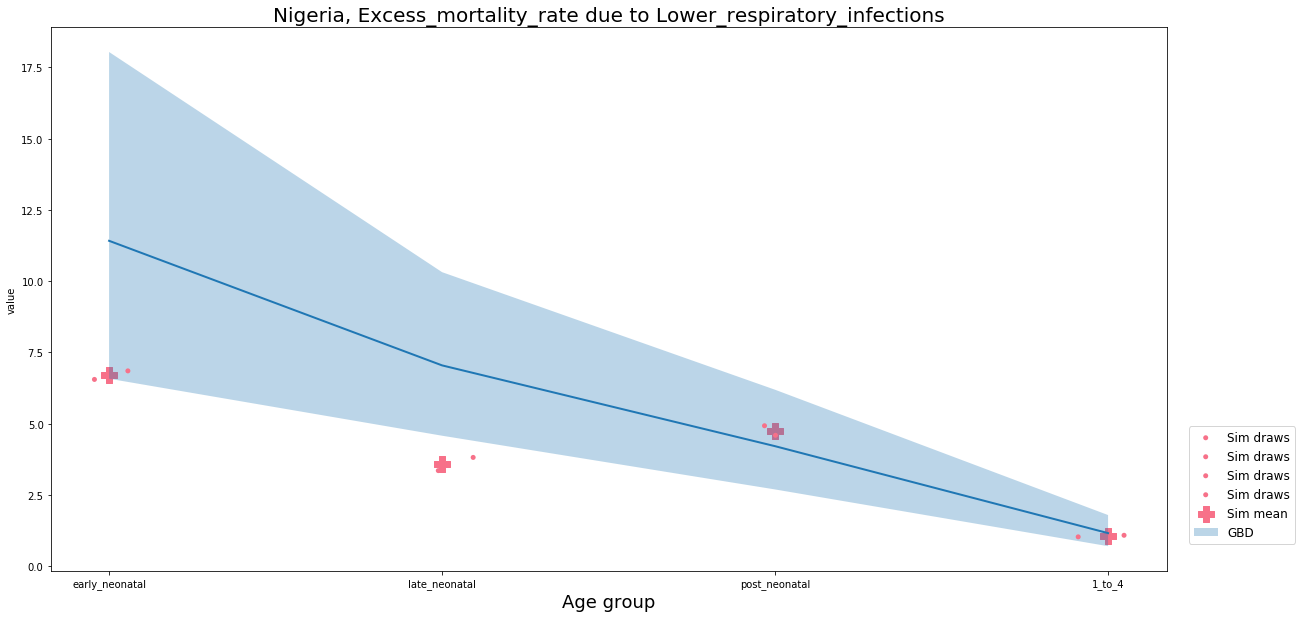

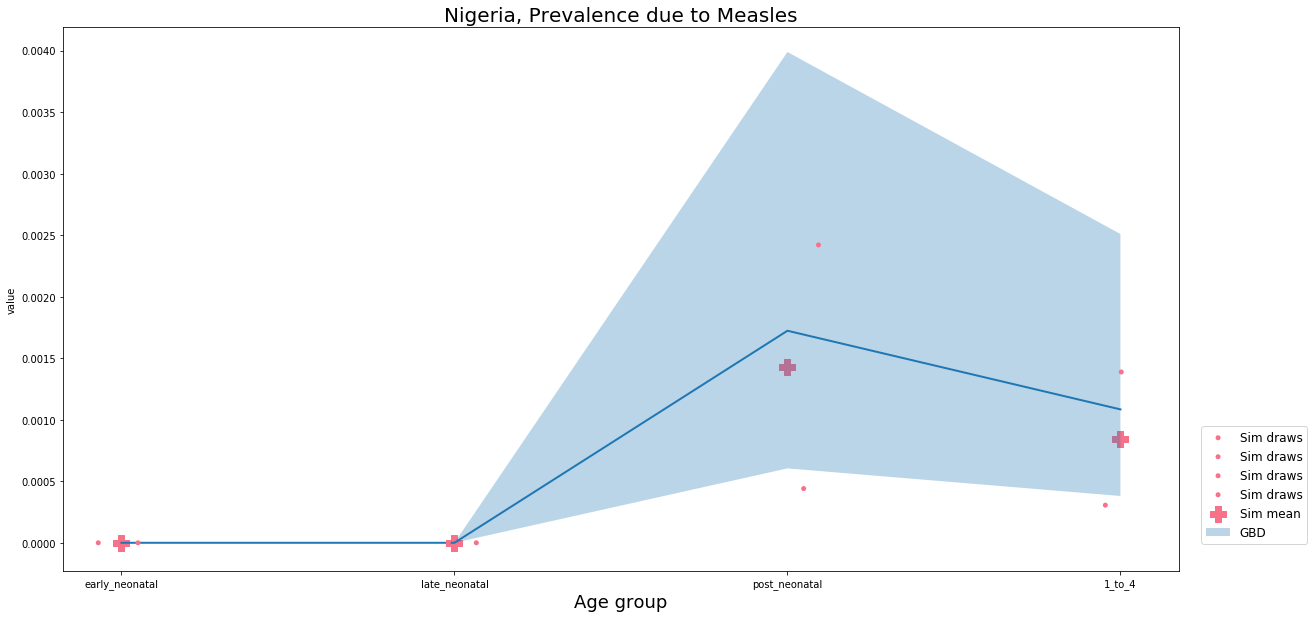

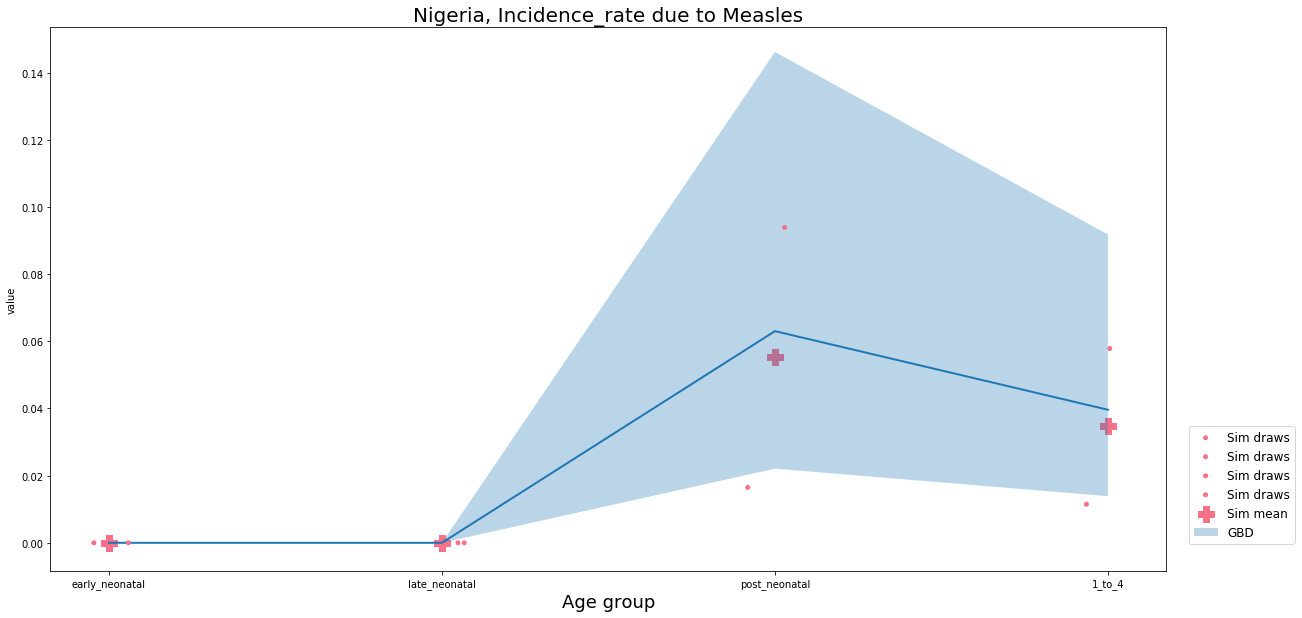

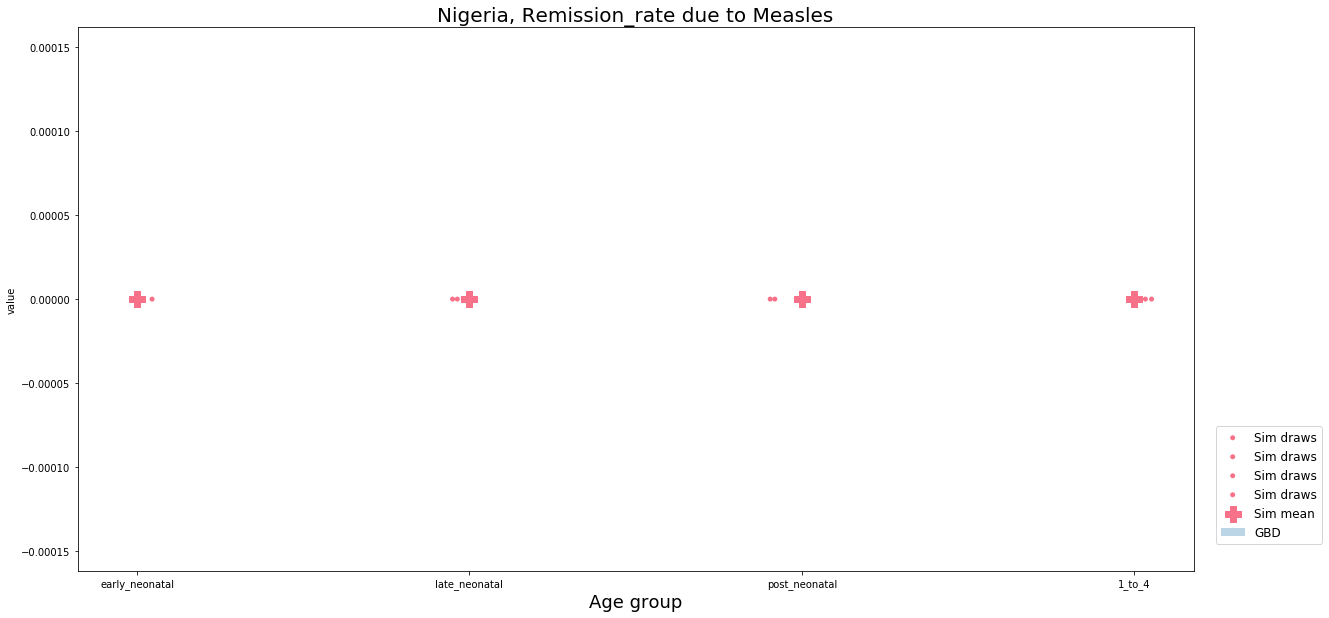

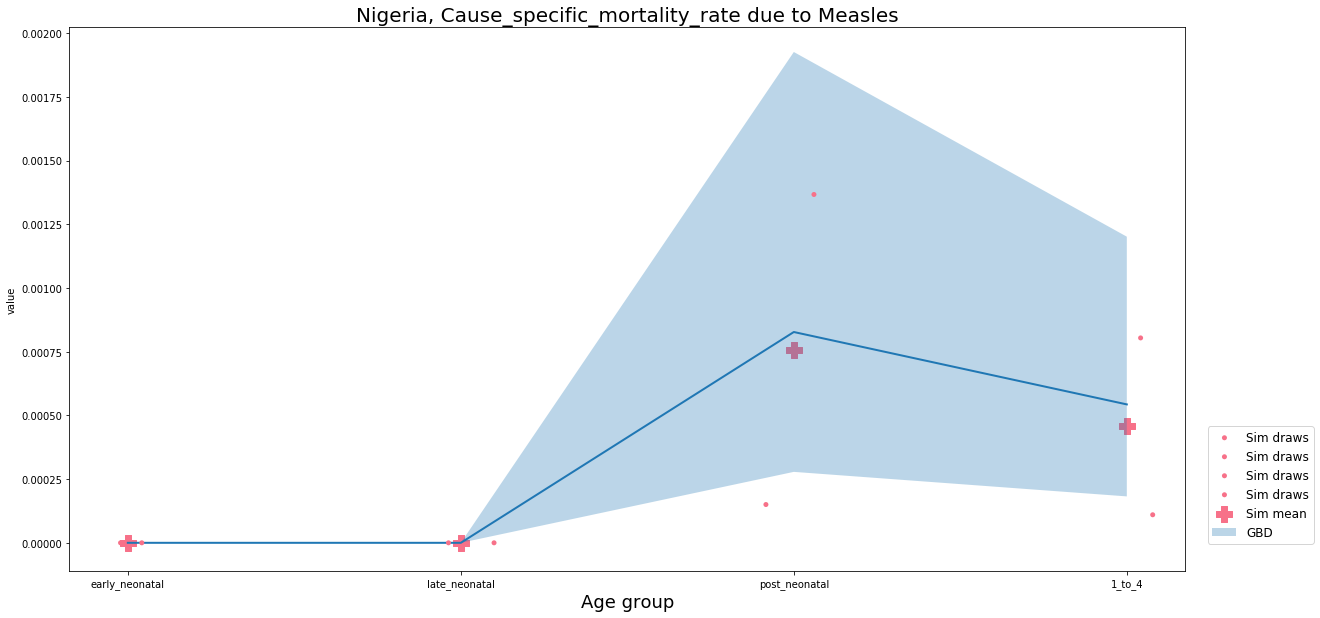

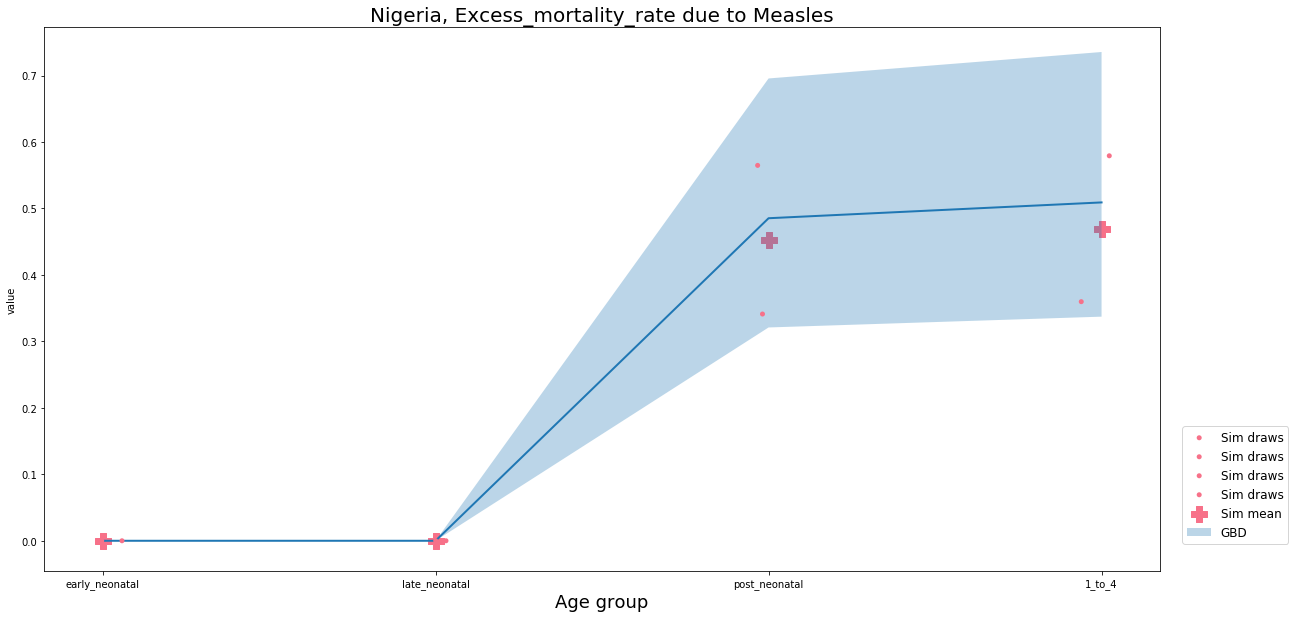

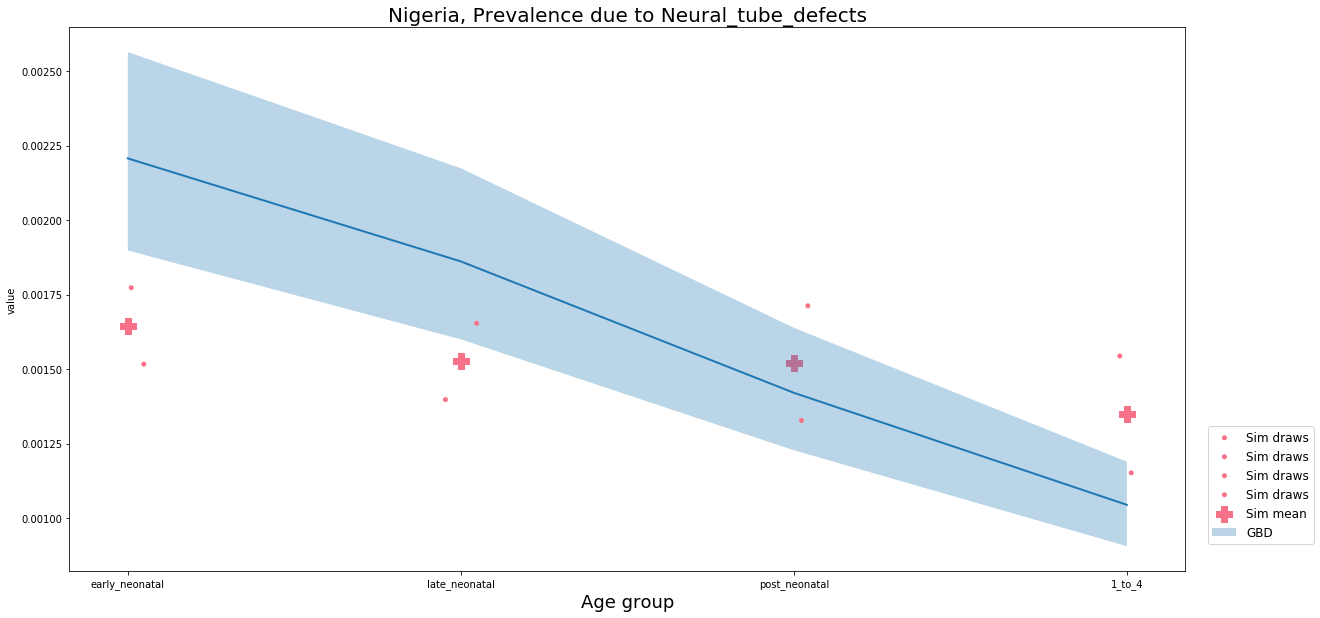

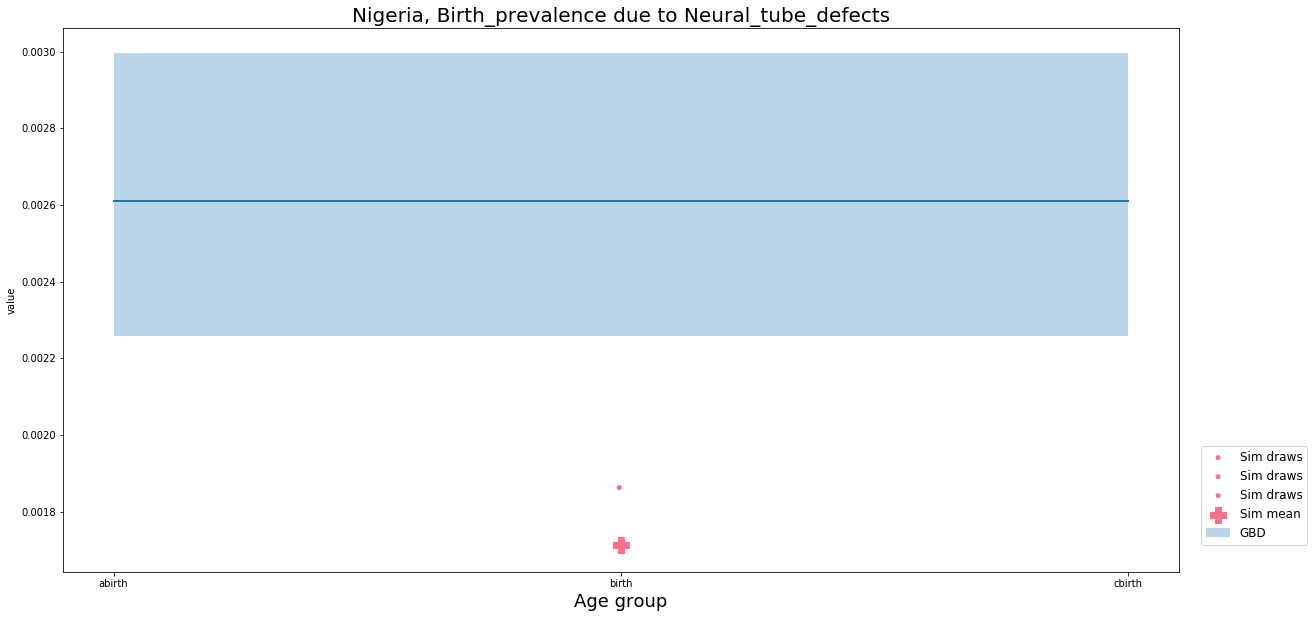

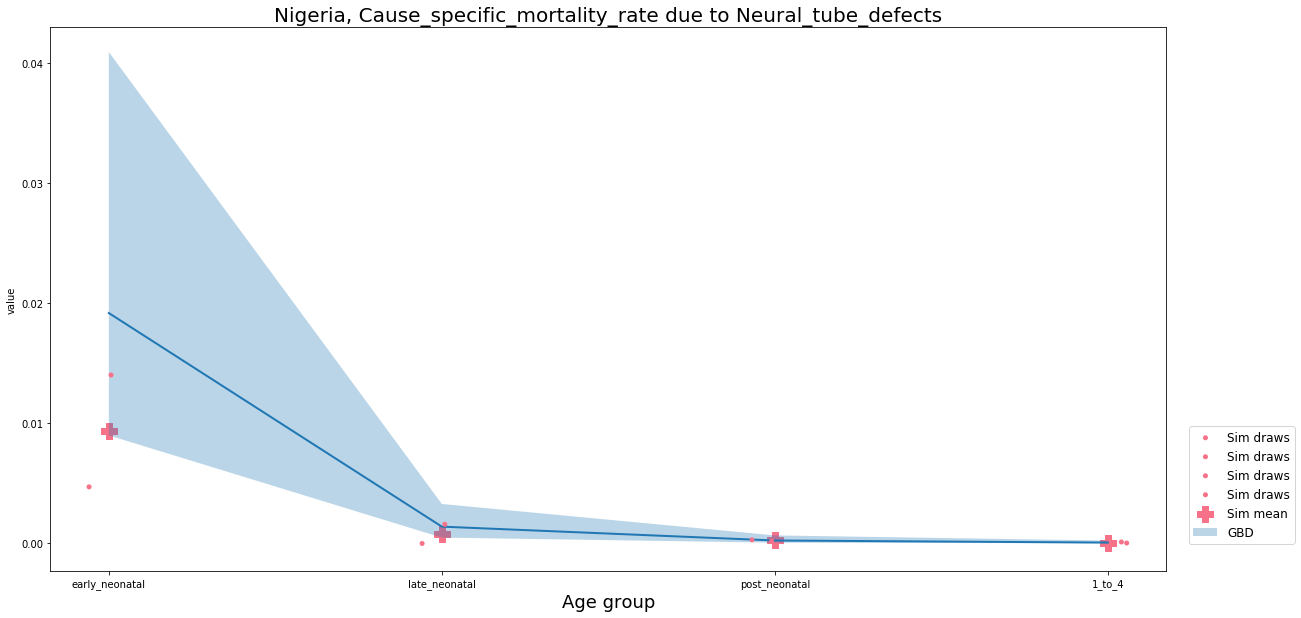

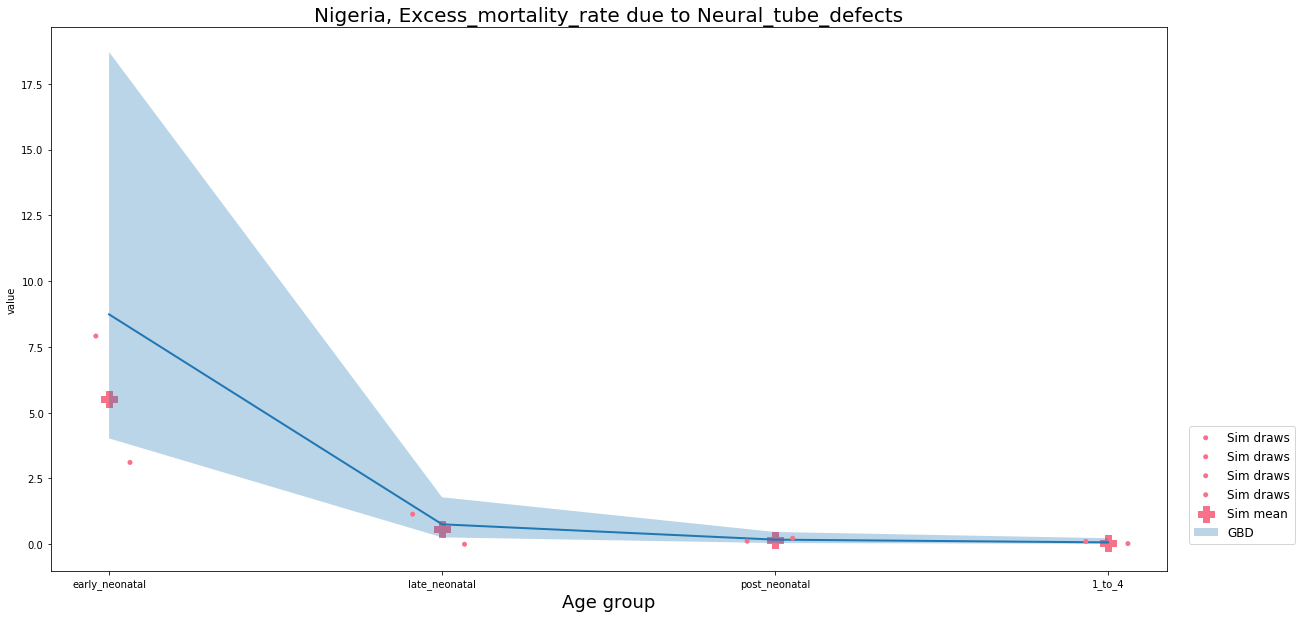

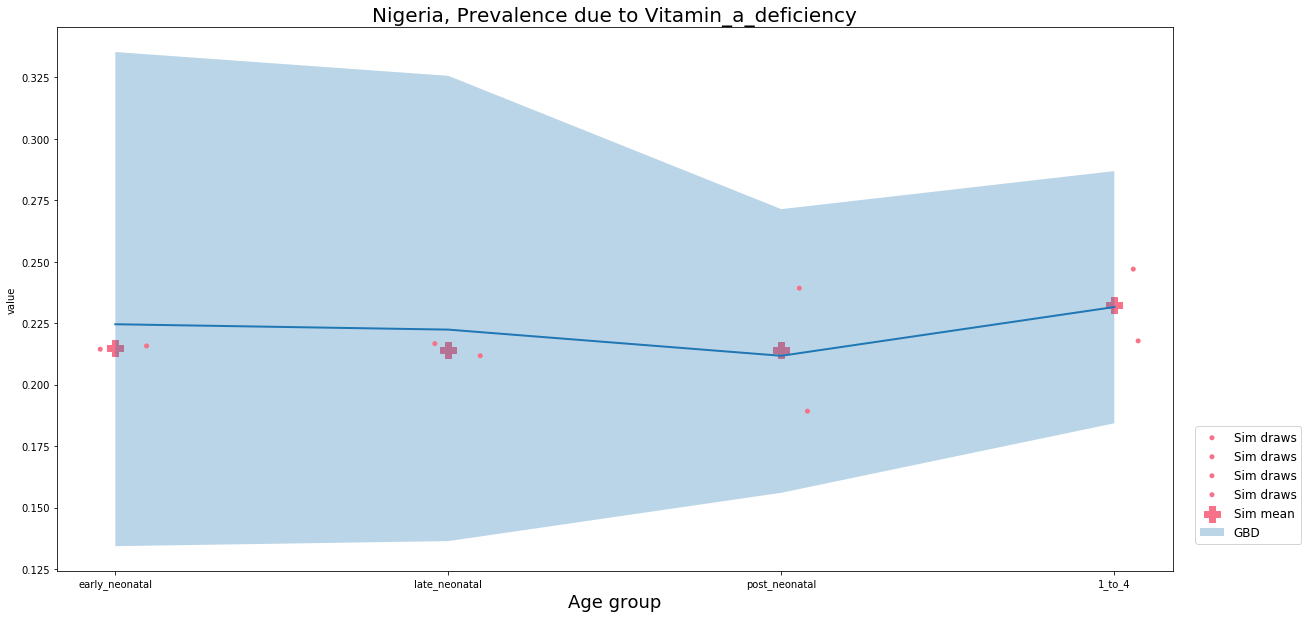

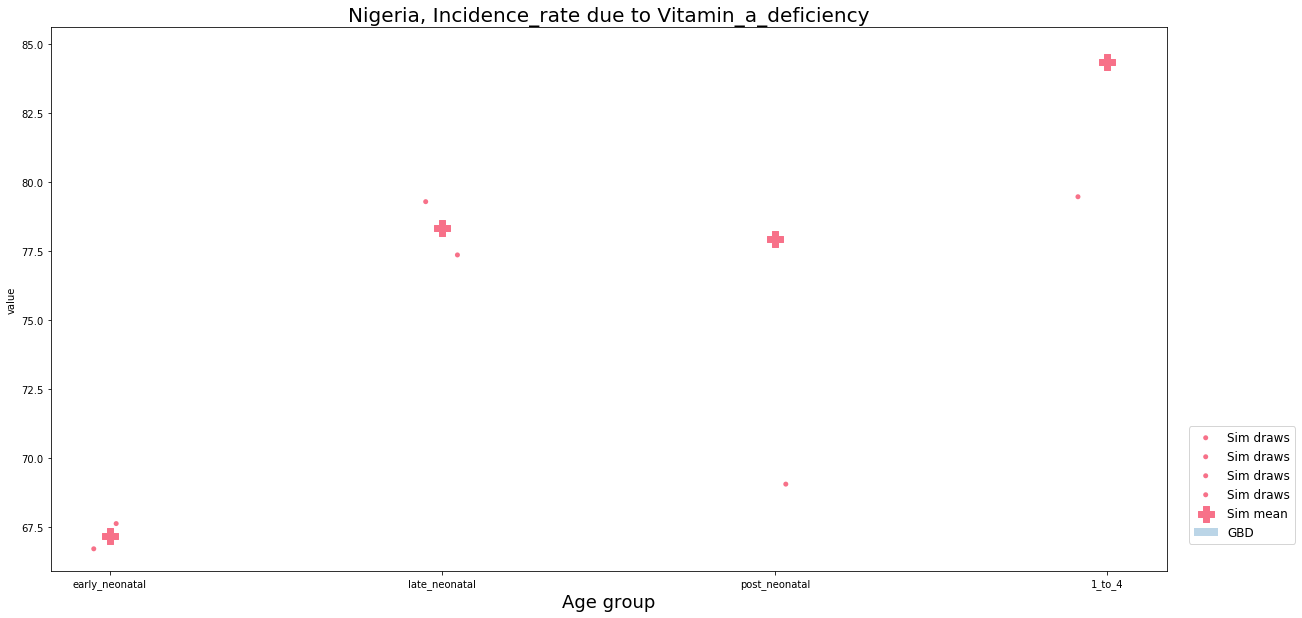

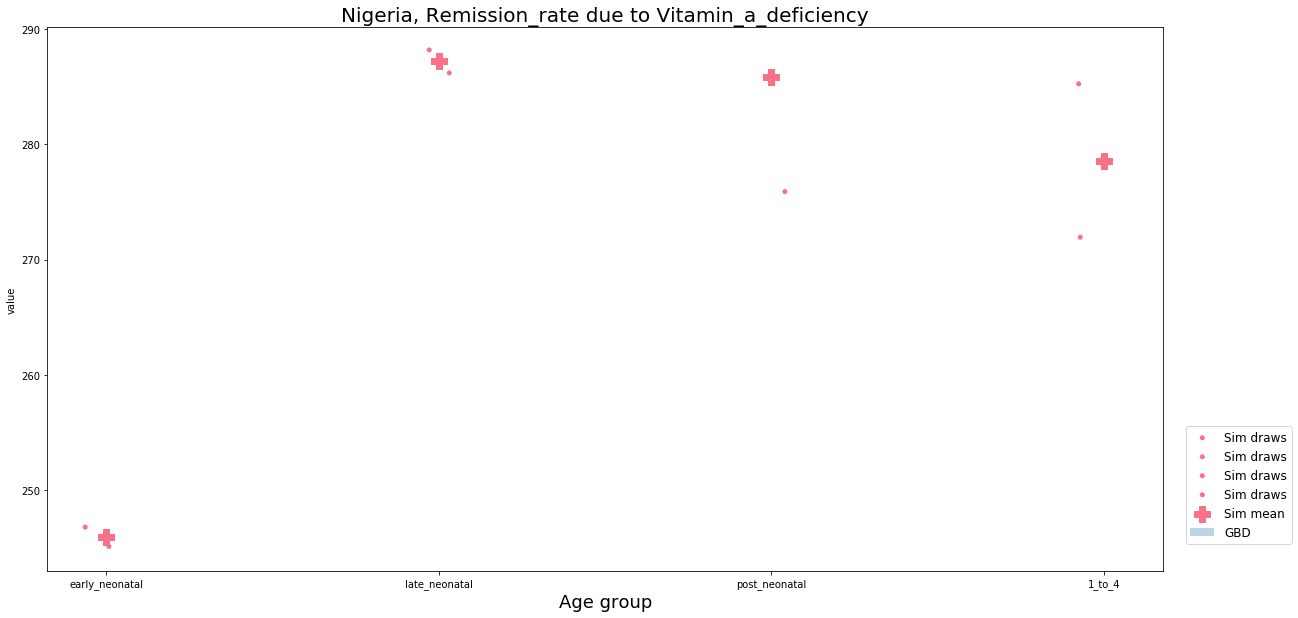

In [15]:
make_multiple_plots(causes)